## Tutorial 4: Low-Level API

### Introduction

The normal way to use TinyQsim is through the QCircuit interface. This manages all the components of the simulator and presents them to the user with a simple API.

It is also possible to use the low-level API of the underlying modules directly, although this is not recommended as the QCircuit interface is simpler to use and likely to be more stable when changes are made to the implementation. However, for anyone who might find it useful, this notebook shows how the low-level interface can be used.

### Imports

The first step is to import the necessary modules:

In [1]:
from tinyqsim import quantum
from tinyqsim.gates import *
from tinyqsim.model import Model
from tinyqsim.plotting import plot_histogram
from tinyqsim.schematic import Schematic
from tinyqsim.simulator import Simulator

### Creating a Circuit

The next step is to create a circuit model and add some gates to it:

In [2]:
nqubits = 2

model = Model(nqubits)
model.add_gate('H', [0])
model.add_gate('X', [1])
model.add_gate('CX', [0, 1])

We can then create a circuit Schematic and ask it to draw the model:

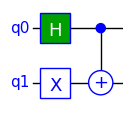

In [3]:
cct = Schematic(nqubits)
cct.draw(model)

### Running the Circuit

Next, a state simulator can be created and asked to execute the model:

In [4]:
sim = Simulator(nqubits)
sim.execute(model)

The state can be printed as follows:

In [5]:
print(sim.state_vector)

[0.         0.70710678 0.70710678 0.        ]


A histogram of the probabilities can be plotted like this:

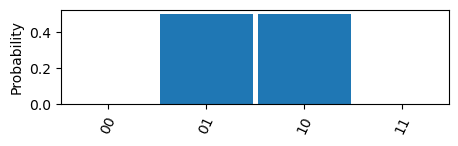

In [6]:
probs = quantum.probability_dict(sim.state_vector, [0, 1])
plot_histogram(probs, ylabel='Probability')

A histogram of measurement counts can be plotted in a similar way:

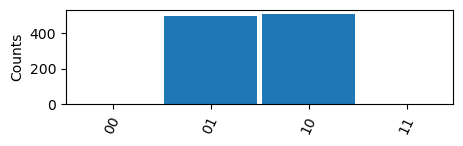

In [7]:
probs = quantum.counts_dict(sim.state_vector, [0, 1])
plot_histogram(probs, ylabel='Counts')

The 'counts' are obtained by resampling the probability distribution of the state vector. This would normally be done at the end of the circuit as an alternative to adding measurements to the output.

Occasionally, a circuit may contain a mid-circuit measurement. In this case, the above approach will not re-execute the internal measurements. The following code shows how counts may be obtained by re-running the whole circuit rather than just resampling the output:

In [8]:
def count_all(model, sim, qubits, runs=1000):
    """Return counts dictionary."""
    counts = np.zeros(2 ** len(qubits), dtype=int)
    for _ in range(runs):
        sim.execute(model)
        probs = quantum.probabilities(sim.state_vector, qubits)
        k = np.random.choice(len(probs), None, p=probs)
        counts[k] += 1
    return dict(zip(quantum.basis_names(len(qubits)), counts))

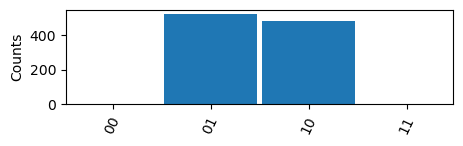

In [9]:
plot_histogram(count_all(model, sim, [0, 1]), ylabel='Counts')

The simulator's 'execute' method accepts an optional parameter 'init' that specifies how the quantum state should be initialized:

In [10]:
# sim.execute(model, init='zeros')  # Initialize state to |00...0>
# sim.execute(model, init='random') # Initialize to random state
# sim.execute(model, init='none')   # Don't reinitialize the state
# sim.execute(model)                # Default is 'zeros'

### Adding more Gates

If more gates are added to the model after it has been run, it is necessary to execute it again. This is illustrated by the following example which adds measurement gates to the circuit and re-runs it:

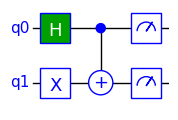

In [11]:
model.add_gate('measure', [0, 1])
cct.draw(model)
sim.execute(model)

The result of any measurement is printed when the circuit is executed, as shown here.

### Qubit Labels

Labels may be added to the qubits as follows:

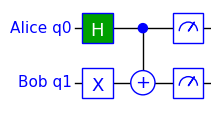

In [12]:
cct.set_labels({0: 'Alice', 1: 'Bob'})
cct.draw(model)

### Final Remarks

TinyQsim's QCircuit class works in incremental mode, so that gates are executed one-at-a-time as they are added to the circuit. This makes it unnecessary to explicitly execute the circuit after creating it. However, when using the low-level API, it is easier to create the circuit and then execute it or adding more gates.

Finally, as mentioned earlier, please be aware that the low-level API mis more lilkely to change if improvements are made to the implementation.